In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline 
import numpy as np 
import cv2
import csv
import matplotlib.pyplot as plt 
import random 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [ ]:
from os import listdir
from os.path import isfile, join
Covid_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/train") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/train", f))]
Covid_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/test") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/test", f))]
Normal_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/train") if  f.startswith('.') == False ]
Normal_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Normal/test", f))]
Pneumonia_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/train") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/train", f))]
Pneumonia_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/test", f))]

In [ ]:
len(Normal_train_files)

180

In [ ]:
def read_data(file_names_list, data_list, labels_list, path, label):
  for i in range(len(file_names_list)):
    img = cv2.imread(path + file_names_list[i])
    img = cv2.resize(img,(224,224))
    data_list.append(img)
    labels_list.append(label)
  return data_list, labels_list

In [ ]:
train_list = []
test_list = []
train_labels = []
test_labels = []

path = "/content/drive/My Drive/Colab Notebooks/Covid/train/"
label = 0
train_list, train_labels = read_data(Covid_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/train/"
label = 1
train_list, train_labels = read_data(Normal_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/train/"
label = 2
train_list, train_labels = read_data(Pneumonia_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Covid/test/"
label = 0
test_list, test_labels = read_data(Covid_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/test/"
label = 1
test_list, test_labels = read_data(Normal_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/test/"
label = 2
test_list, test_labels = read_data(Pneumonia_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))

179 179
359 359
539 539
30 30
60 60
90 90


In [ ]:
k = 10
folds = list(StratifiedKFold(n_splits = k, shuffle=True, random_state=1).split(train_list, train_labels))

In [ ]:
def one_hot(l):
    for i in range(len(l)):
        if(l[i] == 0):
            l[i] = [1,0,0]
        if(l[i] == 1):
            l[i] = [0,1,0]
        if(l[i] == 2):
            l[i] = [0,0,1]
    return l

In [ ]:
train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

In [ ]:
train_list = np.array(train_list)
train_labels = np.array(train_labels)
test_list = np.array(test_list)
test_labels = np.array(test_labels)

In [ ]:
def InceptionV3_get():
    K.set_learning_phase(1)
    ModelX = InceptionV3(weights="imagenet", include_top=False,
                      input_tensor=Input(shape=(224, 224, 3)))
    ModelX_out = ModelX.layers[-1].output
    ModelX_out = GlobalAveragePooling2D()(ModelX_out)
    ModelX_out = Dense(256, activation = "relu", name="dense_one")(ModelX_out)
    ModelX_out = Dropout(0.3, name="dropout_add1")(ModelX_out)
    ModelX_out = Dense(512, activation = "relu", name="dense_two")(ModelX_out)
    ModelX_out = Dropout(0.3, name="dropout_add2")(ModelX_out)
    ModelX_out = Dense(3, activation="softmax", name="dense_out")(ModelX_out)
    ModelDN = Model(ModelX.input, ModelX_out)
    for layer in ModelX.layers:
      if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          layer.trainable = True
          K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
          K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
    #for layer in ModelX.layers:
      #layer.trainable = False

    
    opt = SGD(lr=0.01, decay=0.01 / 25)
    ModelDN.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    return(ModelDN)

In [ ]:
model = InceptionV3_get()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience =  5)
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Covid_19_InceptionV3_best_fold"+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
len(train_list)

539

In [ ]:
models_each_folds = []
models_evaluations = []
HXs = []

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_app = train_list[train_idx]
    Y_train_app = train_labels[train_idx]
    VALX = train_list[val_idx]
    VALY= train_labels[val_idx]
    
    print("[INFO] training head...")
    
    modelX = InceptionV3_get()
    
    HX = modelX.fit_generator(
    trainAug.flow(X_train_app,Y_train_app, batch_size=8),
    steps_per_epoch=len(X_train_app) // 8,
    validation_data=(VALX, VALY),
    validation_steps=len(VALX) // 8,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)
    
    K.set_learning_phase(0)
    predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=8)
    predIdxsX = np.argmax(predIdxsX, axis=1)
    print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))
    
    models_each_folds.append(modelX)
    HXs.append(HX)
    
    Loss, Acc = modelX.evaluate(test_list,test_labels)
    models_evaluations.append([Loss, Acc])
    print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))
  


Fold  0
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.6331
Epoch 00001: val_loss improved from inf to 1.40484, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Covid_19_InceptionV3_best_fold.h5
60/60 [==============================] - 9s 150ms/step - loss: 0.8167 - accuracy: 0.6331 - val_loss: 1.4048 - val_accuracy: 0.4074
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.8176
Epoch 00002: val_loss improved from 1.40484 to 0.90129, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Covid_19_InceptionV3_best_fold.h5
60/60 [==============================] - 7s 119ms/step - loss: 0.4951 - accuracy: 0.8176 - val_loss: 0.9013 - val_accuracy: 0.7407
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8365
Epoch 00003: val_

In [ ]:
test_acc = []
train_acc = []
val_acc = []

for i in range(10):
  H = HXs[i]
  train_acc.append(np.mean(HXs[i].history["accuracy"]))
  val_acc.append(np.mean(HXs[i].history["val_accuracy"]))
  test_acc.append(models_evaluations[i][1])

test_acc_mean = np.mean(test_acc)
train_acc_mean = np.mean(train_acc)
val_acc_mean = np.mean(val_acc)
print(" train accuracy mean:",train_acc_mean,"\n",
      "validation accuracy mean:",val_acc_mean,"\n",
      "test accuracy mean:",test_acc_mean)

 train accuracy mean: 0.904927206163307 
 validation accuracy mean: 0.899257408685855 
 test accuracy mean: 0.7177777767181397


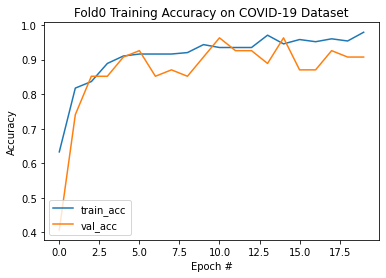

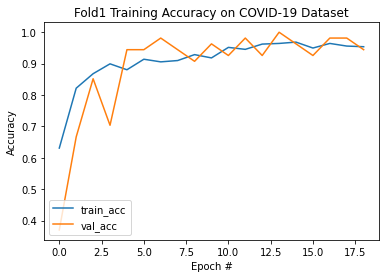

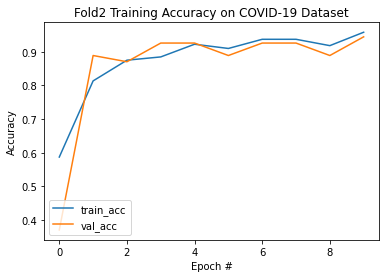

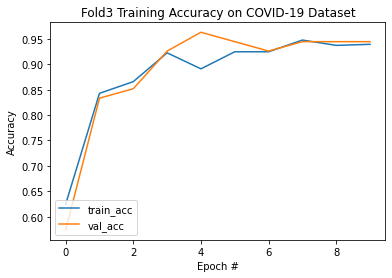

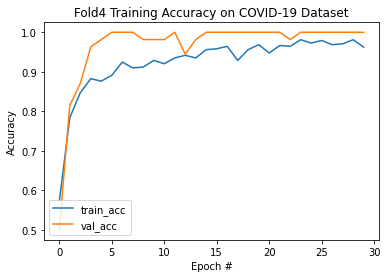

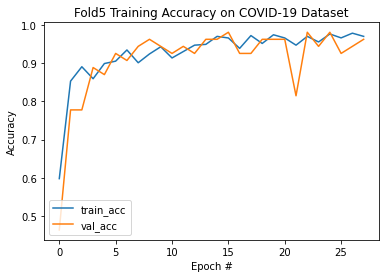

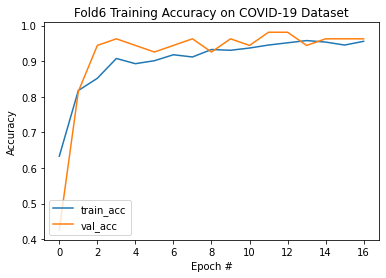

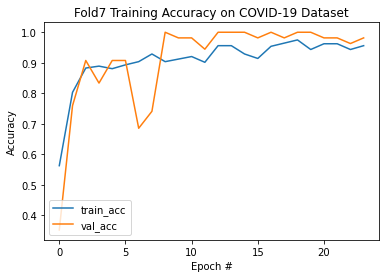

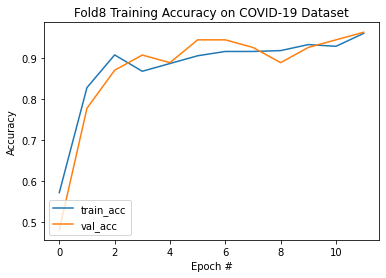

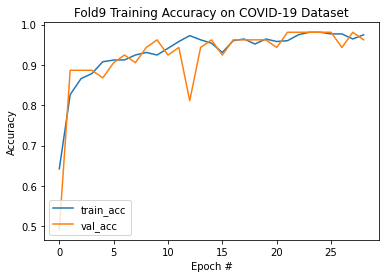

In [ ]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title("Fold"+ str(i)+" Training Accuracy on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Fold_'+ str(i)+'_InceptionV3_Training_Accuracy.png', bbox_inches='tight')

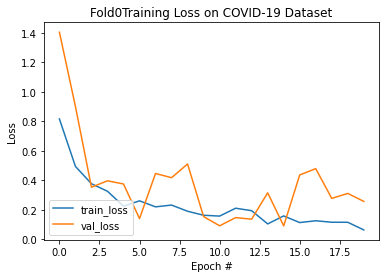

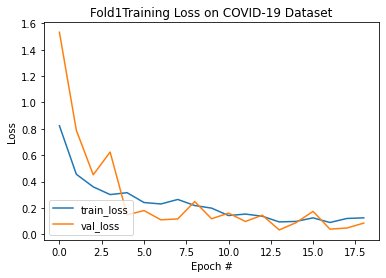

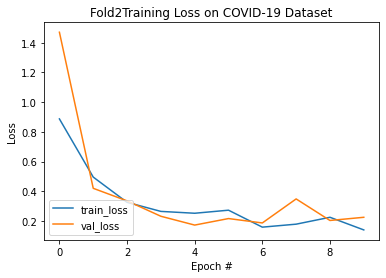

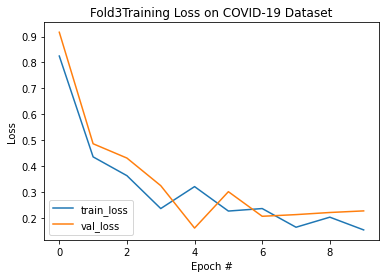

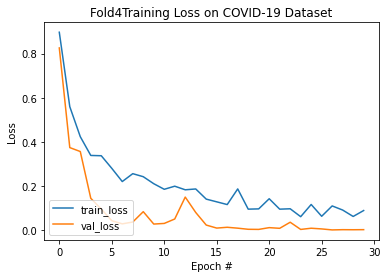

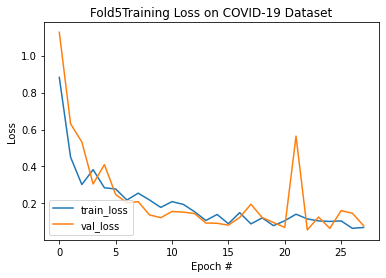

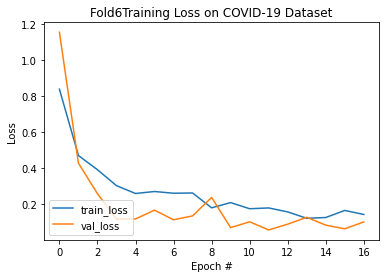

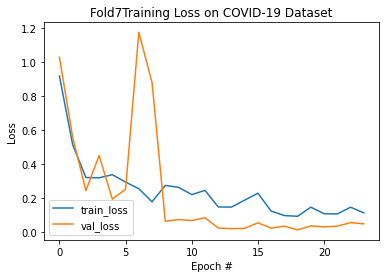

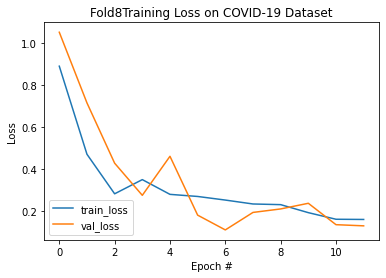

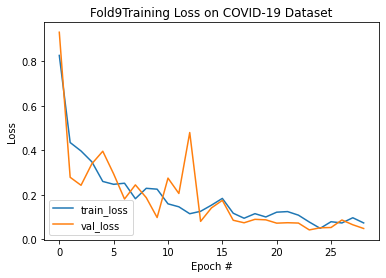

In [ ]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Fold_'+ str(i)+'InceptionV3_Training_Loss.png', bbox_inches='tight')

In [ ]:
modelX = InceptionV3_get()

HX = modelX.fit_generator(
    trainAug.flow(train_list, train_labels, batch_size=15),
    steps_per_epoch=len(train_list) // 15,
    validation_data=(test_list, test_labels),
    validation_steps=len(test_list) // 15,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.5076
Epoch 00001: val_loss did not improve from 0.00132
35/35 [==============================] - 8s 221ms/step - loss: 0.9795 - accuracy: 0.5076 - val_loss: 1.0241 - val_accuracy: 0.5333
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.8397
Epoch 00002: val_loss did not improve from 0.00132
35/35 [==============================] - 6s 180ms/step - loss: 0.5355 - accuracy: 0.8397 - val_loss: 1.0815 - val_accuracy: 0.4667
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8779
Epoch 00003: val_loss did not improve from 0.00132
35/35 [==============================] - 6s 177ms/step - loss: 0.3610 - accuracy: 0.8779 - val_loss: 0.8893 - val_accuracy: 0.6000
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9027
Epoch 00004: val_loss did not improve from 0.00132
35/35 [====================

In [ ]:
K.set_learning_phase(0)
predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=15)
predIdxsX = np.argmax(predIdxsX, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))

              precision    recall  f1-score   support

    COVID-19       0.72      0.93      0.81        30
      NORMAL       0.78      0.47      0.58        30
   PNEUMONIA       0.79      0.87      0.83        30

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.74        90
weighted avg       0.76      0.76      0.74        90



In [ ]:
Loss, Acc = modelX.evaluate(test_list,test_labels)
print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))

1/3 [=========>....................] - ETA: 0s - loss: 0.1202 - accuracy: 0.9375

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/InceptionV3_final_model_Training_Loss.png', bbox_inches='tight')

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_loss")
plt.title("Fold"+ str(i)+"Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/InceptionV3_final_model_Training_Accuracy.png', bbox_inches='tight')

In [ ]:
modelX.save('/content/drive/My Drive/Colab Notebooks/Covid_19_InceptionV3/Covid_19_InceptionV3_final_model.h5')